In [300]:
import pandas as pd
import numpy as np
import gpflow as gpf
from matplotlib import pyplot as plt
#Get R^2 -- Train-Test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [301]:
#import data: 
dat = pd.read_csv('./GP_365_Preprocessed.csv', index_col = 'Unnamed: 0')
print(dat.shape)
dat.head()

(151609, 5)


,site,MonitorData,day,x,y
0,0,5.9,15,3.767606e+06,739558.671618
1,0,11.0,18,3.767606e+06,739558.671618
2,0,8.6,21,3.767606e+06,739558.671618
3,0,6.2,24,3.767606e+06,739558.671618
4,0,7.6,27,3.767606e+06,739558.671618


In [302]:
#only consider points with lat less than 3000000
dat = dat[dat.y < 3000000]

# Look at space domain data 

In [303]:
# Consider all sites for one day: 
dat_d0 = dat[dat.day == 15]
nsites_total = len(dat.site.unique())
nsites_d0 = len(dat_d0.site.unique())
print("fraction of sites on this day: ", nsites_d0 / nsites_total)

fraction of sites on this day:  0.6346955796497081


In [443]:
#Create data 
X_space = dat_d0.loc[:, ['x', 'y']].values
Y_space = dat_d0.MonitorData.values.reshape(-1, 1)
orig_mean_space = Y_space.mean()
Y_space = Y_space - orig_mean_space

In [444]:
#Figure out how sparse I want the inducing points to be 
print(X_space[::5].shape)

(153, 2)


In [445]:
#Generate new sparse model: 
m_space = gpf.models.SVGP(
    X_space, Y_space, kern=gpf.kernels.RBF(2),
    likelihood=gpf.likelihoods.Gaussian(),
    Z=X_space[::5].copy(), whiten=True, q_diag=True)

In [446]:
m_space.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),True,"(153, 2)",True,"[[3767606.00318, 739558.671618], [3807425.5389..."
SVGP/q_mu,Parameter,None,(none),True,"(153, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(153, 1)",True,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [458]:
m_space.kern.lengthscales.trainable = False
m_space.kern.lengthscales = 2e5

In [459]:
m_space.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,7.853356534135257
SVGP/kern/lengthscales,Parameter,None,+ve,False,(),True,200000.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,15.747484089956068
SVGP/feature/Z,Parameter,None,(none),True,"(153, 2)",True,"[[3767606.00316, 739558.671611], [3807425.5389..."
SVGP/q_mu,Parameter,None,(none),True,"(153, 1)",True,"[[-0.229441258537], [-0.651658592319], [1.4651..."
SVGP/q_sqrt,Parameter,None,+ve,True,"(153, 1)",True,"[[0.457555273439], [0.332577949144], [0.493434..."


In [460]:
opt_space = gpf.train.ScipyOptimizer()
opt_space.minimize(m_space)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2192.267127
  Number of iterations: 29
  Number of functions evaluations: 32


In [461]:
m_space.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,8.978515656598255
SVGP/kern/lengthscales,Parameter,None,+ve,False,(),True,200000.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,14.764508694849726
SVGP/feature/Z,Parameter,None,(none),True,"(153, 2)",True,"[[3767606.00316, 739558.671612], [3807425.5389..."
SVGP/q_mu,Parameter,None,(none),True,"(153, 1)",True,"[[-0.201400982424], [-0.568948069332], [1.5158..."
SVGP/q_sqrt,Parameter,None,+ve,True,"(153, 1)",True,"[[0.360280600371], [0.274440508089], [0.434703..."


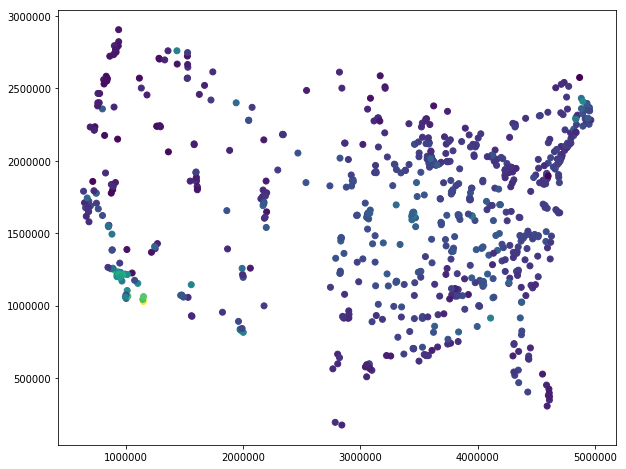

In [462]:
#Show scatter of original points:
plt.figure(figsize=(10,8))
plt.scatter(X_space[:,0], X_space[:,1], c=Y_space[:,0])
plt.show()

In [463]:
#Gen interp (prediction) points
min_lon = 500000
max_lon = 5000000
min_lat = 0
max_lat = 3000000
nlon = 100 #longitudinal points 
nlat = int(nlon * (max_lat - min_lat) / (max_lon - min_lon))
X_preds = np.stack(np.meshgrid(np.linspace(min_lon, max_lon, nlon), np.linspace(min_lat, max_lat, nlat)), -1).reshape(-1, 2)

In [464]:
# plt.figure(figsize=(10,8))
# plt.scatter(X_preds[:,0], X_preds[:,1])
# # plt.show()

In [465]:
Y_preds_mean, Y_preds_var = m_space.predict_y(X_preds)

In [466]:
print(np.min(Y_preds_mean))
print(np.max(Y_preds_mean))

-7.77932136137
18.3482428013


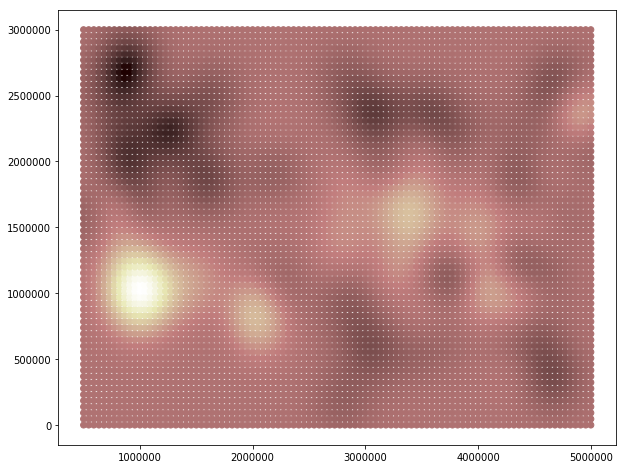

In [467]:
plt.figure(figsize=(10,8))
plt.scatter(X_preds[:,0], X_preds[:,1], c=Y_preds_mean[:,0], cmap = 'pink')
plt.show()

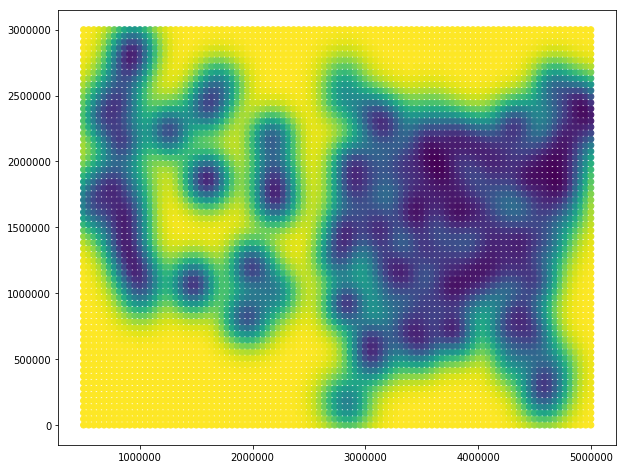

In [468]:
plt.figure(figsize=(10,8))
plt.scatter(X_preds[:,0], X_preds[:,1], c=Y_preds_var[:,0])
plt.show()

### Get $R^2$

In [219]:
X_space_train, X_space_test, Y_space_train, Y_space_test = train_test_split(X_space, Y_space, test_size = 0.2, random_state=42)

In [220]:
#Generate new sparse model: 
m_space_eval = gpf.models.SVGP(
    X_space_train, Y_space_train, kern=gpf.kernels.RBF(2),
    likelihood=gpf.likelihoods.Gaussian(),
    Z=X_space_train[::5].copy(), whiten=True, q_diag=True)

In [221]:
m_space_eval.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),True,"(122, 2)",True,"[[4436300.25234, 1491459.08347], [4643035.3621..."
SVGP/q_mu,Parameter,None,(none),True,"(122, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(122, 1)",True,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [222]:
m_space_eval.kern.lengthscales.trainable = False
m_space_eval.kern.lengthscales = 2e5

In [223]:
m_space_eval.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/lengthscales,Parameter,None,+ve,False,(),True,200000.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),True,"(122, 2)",True,"[[4436300.25234, 1491459.08347], [4643035.3621..."
SVGP/q_mu,Parameter,None,(none),True,"(122, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(122, 1)",True,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [224]:
opt_space_eval = gpf.train.ScipyOptimizer()
opt_space_eval.minimize(m_space_eval)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1775.232732
  Number of iterations: 34
  Number of functions evaluations: 37


In [225]:
m_space_eval.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,9.06927565938696
SVGP/kern/lengthscales,Parameter,None,+ve,False,(),True,200000.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,15.711724446259403
SVGP/feature/Z,Parameter,None,(none),True,"(122, 2)",True,"[[4436300.25233, 1491459.08346], [4643035.3621..."
SVGP/q_mu,Parameter,None,(none),True,"(122, 1)",True,"[[0.129113095505], [-0.233463864443], [0.28177..."
SVGP/q_sqrt,Parameter,None,+ve,True,"(122, 1)",True,"[[0.275265194391], [0.209811470844], [0.342141..."


In [226]:
Y_space_mean_eval, Y_space_var_eval = m_space_eval.predict_y(X_space_test)

In [228]:
R2 = r2_score(Y_space_mean_eval, Y_space_test)
print('Model R^2:', R2.squeeze())

Model R^2: -0.134389333332


# Look at time domain 

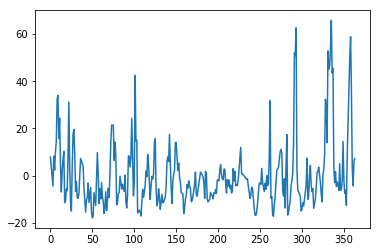

In [237]:
#Consider site 88
dat_s88 = dat[dat.site == 88]

#only use 'day' 
X_s88 = dat_s88.day.values.astype(np.float64).reshape(-1,1)
Y_s88 = dat_s88.MonitorData.values.reshape(-1,1)

#de-mean Y data:
orig_mean_s88 = Y_s88.mean()
Y_s88 = Y_s88 - orig_mean_s88

#Plot the data: 
plt.plot(X_s88, Y_s88)
plt.show()

# Make time-domain GP 

In [246]:
#Generate new sparse model: 
m_time = gpf.models.SVGP(
    X_s88, Y_s88, kern=gpf.kernels.RBF(1),
    likelihood=gpf.likelihoods.Gaussian(),
    Z=X_s88[::5].copy(), whiten=True, q_diag=True)

In [247]:
m_time.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),True,"(67, 1)",True,"[[0.0], [7.0], [12.0], [17.0], [22.0], [27.0],..."
SVGP/q_mu,Parameter,None,(none),True,"(67, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(67, 1)",True,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [248]:
m_time.kern.lengthscales.trainable = False
m_time.kern.lengthscales = 5

In [249]:
m_time.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/lengthscales,Parameter,None,+ve,False,(),True,5.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),True,"(67, 1)",True,"[[0.0], [7.0], [12.0], [17.0], [22.0], [27.0],..."
SVGP/q_mu,Parameter,None,(none),True,"(67, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(67, 1)",True,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [250]:
opt_time = gpf.train.ScipyOptimizer()
opt_time.minimize(m_time)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1288.079556
  Number of iterations: 529
  Number of functions evaluations: 708


In [251]:
m_time.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,137.497838328338
SVGP/kern/lengthscales,Parameter,None,+ve,False,(),True,5.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,88.88967149236419
SVGP/feature/Z,Parameter,None,(none),True,"(67, 1)",True,"[[-5.43295294644], [6.70303913975], [6.7498948..."
SVGP/q_mu,Parameter,None,(none),True,"(67, 1)",True,"[[0.242579857119], [1.30481475605], [1.0527523..."
SVGP/q_sqrt,Parameter,None,+ve,True,"(67, 1)",True,"[[0.780377985341], [0.274520603314], [0.415809..."


In [252]:
#Time points to predict: 
tmin = X_s88.min()
tmax = X_s88.max()
tgrid = np.arange(tmin, tmax + 1).astype(np.float64).reshape(-1,1)

In [253]:
Y_preds_mean_time, Y_preds_var_time = m_time.predict_y(tgrid)
Y_preds_mean_time += orig_mean

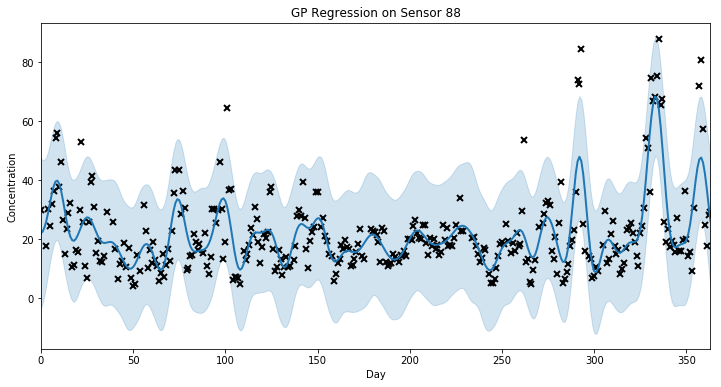

In [469]:
plt.figure(figsize=(12, 6))
plt.plot(X_s88, Y_s88 + orig_mean, 'kx', mew=2)
plt.plot(tgrid, Y_preds_mean_time, 'C0', lw=2)
plt.fill_between(tgrid[:,0],
                 Y_preds_mean_time[:,0] - 2*np.sqrt(Y_preds_var_time[:,0]),
                 Y_preds_mean_time[:,0] + 2*np.sqrt(Y_preds_var_time[:,0]),
                 color='C0', alpha=0.2)
plt.xlim(tmin, tmax)
plt.xlabel('Day')
plt.ylabel('Concentration')
plt.title('GP Regression on Sensor 88')
plt.show()

### Get $R^2$

In [255]:
X_s88_train, X_s88_test, Y_s88_train, Y_s88_test = train_test_split(X_s88, Y_s88, test_size = 0.2, random_state=42)

In [280]:
#Generate new sparse model: 
m_time_eval = gpf.models.SVGP(
    X_s88_train, Y_s88_train, kern=gpf.kernels.RBF(1),
    likelihood=gpf.likelihoods.Gaussian(),
    Z=X_s88_train[::5].copy(), whiten=True, q_diag=True)

In [281]:
m_time_eval.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),True,"(53, 1)",True,"[[246.0], [275.0], [123.0], [193.0], [252.0], ..."
SVGP/q_mu,Parameter,None,(none),True,"(53, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(53, 1)",True,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [282]:
m_time_eval.kern.lengthscales.trainable = False
m_time_eval.kern.lengthscales = 5

In [283]:
m_time_eval.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/lengthscales,Parameter,None,+ve,False,(),True,5.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),True,"(53, 1)",True,"[[246.0], [275.0], [123.0], [193.0], [252.0], ..."
SVGP/q_mu,Parameter,None,(none),True,"(53, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(53, 1)",True,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [285]:
opt_time_eval = gpf.train.ScipyOptimizer()
opt_time_eval.minimize(m_time_eval)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1049.530522
  Number of iterations: 2
  Number of functions evaluations: 4


In [286]:
m_time_eval.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,100.82001963034489
SVGP/kern/lengthscales,Parameter,None,+ve,False,(),True,5.0
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,112.1173624258188
SVGP/feature/Z,Parameter,None,(none),True,"(53, 1)",True,"[[237.146377397], [276.162022949], [127.714365..."
SVGP/q_mu,Parameter,None,(none),True,"(53, 1)",True,"[[-0.495561658947], [0.35483034657], [-0.60202..."
SVGP/q_sqrt,Parameter,None,+ve,True,"(53, 1)",True,"[[0.365584222891], [0.356091814253], [0.400570..."


In [293]:
Y_time_mean_eval, Y_time_var_eval = m_time_eval.predict_y(X_s88_test)

In [294]:
R2 = r2_score(Y_time_mean_eval, Y_s88_test)
print('Model R^2:', R2.squeeze())

Model R^2: -0.303867736239


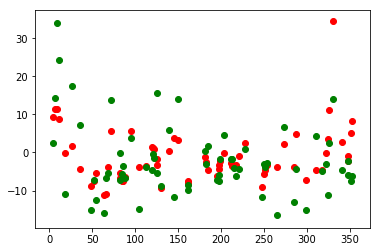

In [298]:
plt.scatter(X_s88_test, Y_time_mean_eval, c='red')
plt.scatter(X_s88_test, Y_s88_test, c='green')
plt.show()

# Make 3D model with lengthscale = 2e5 and timescale = 5days 
Only consider the first 10 days available 

In [55]:
dat_3d = dat.copy()
dat_3d = dat_3d[dat_3d.day < dat_3d.day.unique()[10]]
Y_3d = dat_3d.MonitorData.values.reshape(-1,1)
X_3d = dat_3d.loc[:, ['x', 'y', 'day']].values.astype(np.float64)

#de-mean Y data:
orig_mean = Y_3d.mean()
Y_3d = Y_3d - orig_mean

In [94]:
len(X_3d[::200])

139

In [95]:
#Generate new sparse model: 
m_3d = gpf.models.SVGP(
    X_3d, Y_3d, kern=gpf.kernels.RBF(3, ARD=True),
    likelihood=gpf.likelihoods.Gaussian(),
    Z=X_3d[::200].copy(), whiten=True, q_diag=True)

In [96]:
m_3d.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/lengthscales,Parameter,None,+ve,True,"(3,)",True,"[1.0, 1.0, 1.0]"
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),True,"(139, 3)",True,"[[3767606.00318, 739558.671618, 15.0], [381212..."
SVGP/q_mu,Parameter,None,(none),True,"(139, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(139, 1)",True,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [97]:
m_3d.kern.lengthscales.trainable = False
m_3d.kern.lengthscales = [2e5, 2e5, 5]

In [98]:
m_3d.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/lengthscales,Parameter,None,+ve,False,"(3,)",True,"[200000.0, 200000.0, 5.0]"
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),True,"(139, 3)",True,"[[3767606.00318, 739558.671618, 15.0], [381212..."
SVGP/q_mu,Parameter,None,(none),True,"(139, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(139, 1)",True,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [99]:
opt_time = gpf.train.ScipyOptimizer()
opt_time.minimize(m_3d)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 96164.224081
  Number of iterations: 396
  Number of functions evaluations: 431


In [100]:
m_3d.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,4.390802161288615
SVGP/kern/lengthscales,Parameter,None,+ve,False,"(3,)",True,"[200000.0, 200000.0, 5.0]"
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,58.2109479030112
SVGP/feature/Z,Parameter,None,(none),True,"(139, 3)",True,"[[3767605.99211, 739558.671264, 10.6352299261]..."
SVGP/q_mu,Parameter,None,(none),True,"(139, 1)",True,"[[-2.04749839898], [-0.906935271947], [-1.1318..."
SVGP/q_sqrt,Parameter,None,+ve,True,"(139, 1)",True,"[[0.525489953621], [0.372865514261], [0.622650..."


In [101]:
#Gen interp (prediction) points in space
min_lon = 500000
max_lon = 5000000
min_lat = 0
max_lat = 3000000
nlon = 100 #longitudinal points 
nlat = int(nlon * (max_lat - min_lat) / (max_lon - min_lon))
X_preds = np.stack(np.meshgrid(np.linspace(min_lon, max_lon, nlon), np.linspace(min_lat, max_lat, nlat)), -1).reshape(-1, 2)

In [102]:
#Time points to predict: 
tmin = dat_3d.day.min()
tmax = dat_3d.day.max()
tgrid = np.arange(tmin, tmax + 1).astype(np.float64).reshape(-1,1)

In [103]:
#Make space/time prediction points
X_3d_pts = np.c_[X_preds, np.ones((X_preds.shape[0], 1))*tgrid[0]]
for day in tgrid[1:]: 
    X_3d_this_day = np.c_[X_preds, np.ones((X_preds.shape[0], 1))*day]
    X_3d_pts = np.r_[X_3d_pts, X_3d_this_day]

In [104]:
Y_preds_mean_3d, Y_preds_var_3d = m_3d.predict_y(X_3d_pts)
Y_preds_mean_3d += orig_mean

In [105]:
print(X_3d_pts[:,0:2].shape)

(475200, 2)


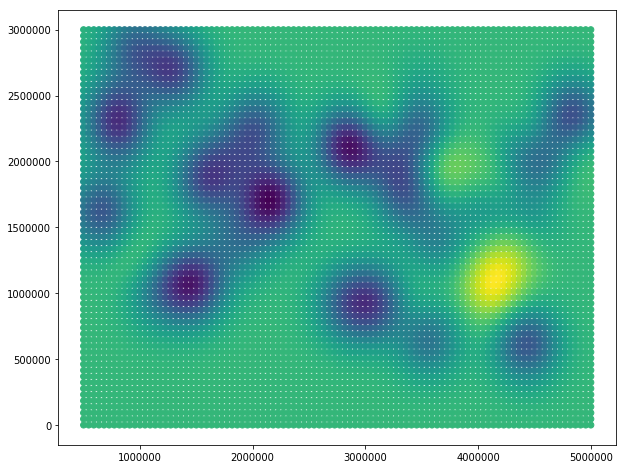

In [290]:
plt.figure(figsize=(10,8))
day_idx = 60 #between 0 and 71
X_pts = X_3d_pts[X_3d_pts[:,2] == day_idx, 0:2]
Y_preds = Y_preds_mean_3d[X_3d_pts[:,2] == day_idx]
plt.scatter(X_pts[:,0], X_pts[:,1], c=Y_preds[:,0])
plt.show()

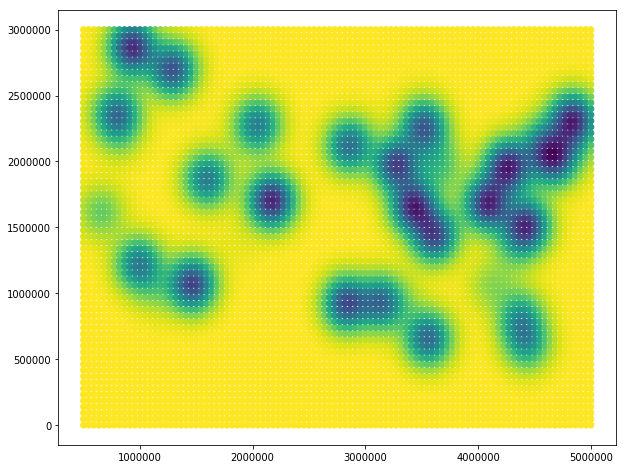

In [291]:
plt.figure(figsize=(10,8))
X_pts = X_3d_pts[X_3d_pts[:,2] == day_idx, 0:2]
Y_var = Y_preds_var_3d[X_3d_pts[:,2] == day_idx]
plt.scatter(X_pts[:,0], X_pts[:,1], c=Y_var[:,0])
plt.show()

### Produce Animation

In [184]:
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image

In [193]:
# First set up the figure, the axis, and the plot element we want to animate
day_idx = 0 #between 0 and 71
X_pts = X_3d_pts[X_3d_pts[:,2] == day_idx, 0:2]
Y_preds = Y_preds_mean_3d[X_3d_pts[:,2] == day_idx]

fig = plt.figure(figsize=(7, 7))
day_id = 0
scat = ax.scatter(X_pts[:, 0], X_pts[:,1], c=Y_preds[:,0])

In [194]:
def update(day): 
    # Update the scatter collection, with the new colors, sizes and positions.
    global X_3d_pts, Y_preds_mean_3d, scat
    X_pts = X_3d_pts[X_3d_pts[:,2] == day, 0:2]
    Y_preds = Y_preds_mean_3d[X_3d_pts[:,2] == day]
    colors = Y_preds[:,0]
    scat.set_x = X_pts[:,0]
    scat.set_y = X_pts[:,1]
    scat.set_c = Y_preds
    return scat

days = np.arange(tmin, tmax + 1)

In [195]:
animation = FuncAnimation(fig, update, interval=10, frames=days)
plt.show()

<Figure size 504x504 with 0 Axes>

In [196]:
plt.show()

# Get $R^2$

In [118]:
X_3d_train, X_3d_test, Y_3d_train, Y_3d_test = train_test_split(X_3d, Y_3d, test_size = 0.2, random_state=42)

In [121]:
#Generate new sparse model: 
m_3d_eval = gpf.models.SVGP(
    X_3d_train, Y_3d_train, kern=gpf.kernels.RBF(3, ARD=True),
    likelihood=gpf.likelihoods.Gaussian(),
    Z=X_3d_train[::200].copy(), whiten=True, q_diag=True)

In [122]:
m_3d_eval.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/lengthscales,Parameter,None,+ve,True,"(3,)",True,"[1.0, 1.0, 1.0]"
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),True,"(111, 3)",True,"[[4109629.21446, 2025808.60867, 45.0], [292122..."
SVGP/q_mu,Parameter,None,(none),True,"(111, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(111, 1)",True,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [123]:
m_3d_eval.kern.lengthscales.trainable = False
m_3d_eval.kern.lengthscales = [2e5, 2e5, 5]

In [124]:
m_3d_eval.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/lengthscales,Parameter,None,+ve,False,"(3,)",True,"[200000.0, 200000.0, 5.0]"
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),True,"(111, 3)",True,"[[4109629.21446, 2025808.60867, 45.0], [292122..."
SVGP/q_mu,Parameter,None,(none),True,"(111, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVGP/q_sqrt,Parameter,None,+ve,True,"(111, 1)",True,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [125]:
opt_3d_eval = gpf.train.ScipyOptimizer()
opt_3d_eval.minimize(m_3d_eval)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 77424.609569
  Number of iterations: 282
  Number of functions evaluations: 317


In [126]:
m_3d_eval.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/variance,Parameter,None,+ve,True,(),True,4.203978139389011
SVGP/kern/lengthscales,Parameter,None,+ve,False,"(3,)",True,"[200000.0, 200000.0, 5.0]"
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,61.06243840528112
SVGP/feature/Z,Parameter,None,(none),True,"(111, 3)",True,"[[4109629.206, 2025808.60591, 36.9016605904], ..."
SVGP/q_mu,Parameter,None,(none),True,"(111, 1)",True,"[[6.15963387469], [1.17582013516], [3.29350346..."
SVGP/q_sqrt,Parameter,None,+ve,True,"(111, 1)",True,"[[0.328759273183], [0.510088456582], [0.398312..."


In [134]:
Y_preds_mean_3d_eval, Y_preds_var_3d_eval = m_3d_eval.predict_y(X_3d_test)

In [135]:
from sklearn.metrics import r2_score
R2 = r2_score(Y_preds_mean_3d_eval, Y_3d_test)
print('Model R^2:', R2.squeeze())

Model R^2: -3.21792892688
